# Modeling 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, avg, format_number, mean, month, year, unix_timestamp,
    date_format, when, round, expr, weekofyear, log
)
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error



warnings.filterwarnings('ignore')


### Reading data

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 ")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

23/08/20 19:34:43 WARN Utils: Your hostname, LAPTOP-D9335T9D resolves to a loopback address: 127.0.1.1; using 192.168.0.77 instead (on interface wifi0)
23/08/20 19:34:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/20 19:34:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Reading taxi records and weather data 

In [3]:
taxi_sdf = spark.read.parquet('../data/curated/taxi_data/*')
weather_sdf = spark.read.parquet('../data/curated/weather_data/*')

In [4]:
taxi_sdf.count()/6

5993384.833333333

In [5]:
file_path = "../data/curated/taxi_zone_gdf/taxi_zone_gdf.geojson"

# Read the GeoPandas DataFrame from the specified file
gdf = gpd.read_file(file_path)
location = spark.createDataFrame(gdf[["LocationID", "Borough"]])


In [6]:
taxi_sdf = taxi_sdf.join(location, location['LocationID']==taxi_sdf["pulocationid"], "inner")
taxi_sdf = taxi_sdf.drop('LocationID')

In [7]:
taxi_sdf = taxi_sdf.filter(F.col("Borough") == 'Manhattan')

#### Group the taxi data by daily hourly time

In [8]:
# Group by the hour of the day and calculate the average trip duration and tip amount
gb_taxi = taxi_sdf.groupBy('pickup_day',"hour").agg(
    F.count("*").alias("trip_count"),
)

#### Joinging the grouped taxi data with weather data 

From analysis section we decided to use 

conditions_index, day_of_week_index, hour, temp, log(windspeed), humindity

In [9]:
# Join the taxi and weather data, based on date and hour time 
full_sdf = gb_taxi.join(weather_sdf, (gb_taxi["pickup_day"] == weather_sdf["date"]) & (gb_taxi["hour"] == weather_sdf["hour_of_the_day"]), "inner")

# transform the windspeed with natural log
full_sdf = full_sdf.withColumn('log(windspeed)', log(full_sdf['windspeed']+1)) # add 1 to aviod zero windspeed

# Drop irrelevant feature to form our traning data 
train = full_sdf.drop("pickup_day", "hour_of_the_day", 'snow', 'feelslike', 'sealevelpressure', 'date' ,'windspeed', 'cloudcover')


In [10]:
train

hour,trip_count,temp,humidity,conditions,day_of_the_week,log(windspeed)
22,6427,-2.9,77.34,Clear,Weekday,2.7536607123542622
10,7581,-5.8,56.47,Clear,Weekend,2.4849066497880004
13,8958,-1.2,65.8,Clear,Weekday,3.1441522786722644
19,14777,-0.5,26.19,Clear,Weekday,2.714694743820879
21,12783,-6.2,56.11,Clear,Weekday,2.379546134130174
23,4530,-2.2,49.49,Clear,Weekday,2.272125885509337
4,735,-0.1,72.15,Clear,Weekday,3.2188758248682006
22,13361,-2.6,52.48,Clear,Weekday,2.747270914255491
2,1028,0.0,55.54,Clear,Weekday,2.3608540011180215
0,1748,16.9,93.74,Overcast,Weekday,2.70805020110221


### import the test data that we have already sampeld and merged from curated data

In [11]:
test = spark.read.parquet('../data/curated/test_data/*')


In [12]:
test

hour,trip_count,temp,humidity,conditions,day_of_the_week,log(windspeed)
11,5540,0.5,84.41,Partially cloudy,Weekday,2.9652730660692823
12,5630,4.9,34.59,Partially cloudy,Weekend,2.6602595372658615
21,5834,6.7,30.48,Clear,Weekend,2.186051276738094
17,6589,7.8,41.32,Clear,Weekday,2.33214389523559
7,1321,2.8,65.8,Clear,Weekend,0.26236426446749106
10,5784,1.0,48.88,Clear,Weekday,2.33214389523559
1,4976,2.8,61.18,Overcast,Weekend,2.341805806147327
21,8580,8.9,76.3,Clear,Weekday,1.916922612182061
2,3808,2.2,66.51,Overcast,Weekend,2.3513752571634776
19,4933,4.4,93.18,Partially cloudy,Weekend,0.09531017980432493


# Apply model

In [13]:
train_data = train
test_data = test

#### Indexing the feature and assemble features in a vector column

In [14]:
# categorical data to be index
categorical_features = ["day_of_the_week", "conditions"]

# Apply string indexing to categorical features
indexers = [StringIndexer(inputCol=feature, outputCol=f"{feature}_index") for feature in categorical_features]

train_indexed_data = train_data
test_indexed_data = test_data

for indexer in indexers:
    train_indexed_data = indexer.fit(train_indexed_data).transform(train_indexed_data)
    test_indexed_data = indexer.fit(test_indexed_data).transform(test_indexed_data)


# Assemble features into a vector column
feature_columns = ["day_of_the_week_index", "conditions_index", "hour", "temp", "log(windspeed)", "humidity"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

train_data_with_features = assembler.transform(train_indexed_data)
test_data_with_features = assembler.transform(test_indexed_data)

###### create a dataframe to store predited and actual hourly taxi demand

In [15]:
result = test_data.select("hour", "trip_count").toPandas()

### Linear regression 

In [16]:
# Create a LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="trip_count")

# Fit the model to the training data
lr_model = lr.fit(train_data_with_features)

# Make predictions on the test data 
test_predictions = lr_model.transform(test_data_with_features)

# save the prediction to the result dataframe
result["linear regression prediction"] =test_predictions.select("prediction").toPandas()


23/08/20 19:35:40 WARN Instrumentation: [76568076] regParam is zero, which might cause numerical instability and overfitting.


### Random Forest Regression

In [17]:
# Create a RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="trip_count")

# Fit the model to the training data
rf_model = rf.fit(train_data_with_features)

# Make predictions on the test data
test_predictions = rf_model.transform(test_data_with_features)

# save the prediction to the result dataframe
result["rf regression prediction"] =test_predictions.select("prediction").toPandas()


### KNN

Spark's MLlib library doesn't have a built-in k-nearest neighbors (KNN) regressor.

 KNeighborsRegressor from scikit-learn

 thus we will need to convert our data to pandas

In [18]:
# Convert the indexed train and test data to Pandas DataFrames
train_data_pandas = train_indexed_data.toPandas()
test_data_pandas = test_indexed_data.toPandas()

In [19]:
test_data_pandas

,hour,trip_count,temp,humidity,conditions,day_of_the_week,log(windspeed),day_of_the_week_index,conditions_index
0,11,5540,0.5,84.41,Partially cloudy,Weekday,2.965273,0.0,1.0
1,12,5630,4.9,34.59,Partially cloudy,Weekend,2.660260,1.0,1.0
2,21,5834,6.7,30.48,Clear,Weekend,2.186051,1.0,0.0
3,17,6589,7.8,41.32,Clear,Weekday,2.332144,0.0,0.0
4,7,1321,2.8,65.80,Clear,Weekend,0.262364,1.0,0.0
...,...,...,...,...,...,...,...,...,...
714,23,6589,-1.2,50.51,Clear,Weekday,0.182322,0.0,0.0
715,11,5558,3.3,47.85,Overcast,Weekday,1.987874,0.0,2.0
716,10,5087,4.9,50.73,Clear,Weekday,2.332144,0.0,0.0
717,3,478,2.9,71.51,Clear,Weekday,2.116256,0.0,0.0


In [20]:
# Prepare the features and target
feature_columns = ["day_of_the_week_index", "conditions_index", "hour", "temp", "log(windspeed)", "humidity"]
X_train = train_data_pandas[feature_columns]
y_train = train_data_pandas["trip_count"]
X_test = test_data_pandas[feature_columns]
y_test = test_data_pandas["trip_count"]


In [21]:
# Create a KNeighborsRegressor model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
knn_test_predictions = knn.predict(X_test)

# save to result dataframe
result["k(5)nn regression prediction"] =knn_test_predictions


In [22]:
average_result = result.groupby("hour").agg(
    actual_average_taxi_demand=pd.NamedAgg(column="trip_count", aggfunc="mean"),
    average_lr_prediction=pd.NamedAgg(column="linear regression prediction", aggfunc="mean"),
    average_rf_prediciton=pd.NamedAgg(column="rf regression prediction", aggfunc="mean"),
    average_k5nn_prediction=pd.NamedAgg(column="k(5)nn regression prediction", aggfunc = 'mean')
).reset_index()


In [23]:
# Convert Pandas Series to Numpy arrays for indexing
hour_values = average_result["hour"].values
actual_average_demand = average_result["actual_average_taxi_demand"].values
average_ls_pred = average_result["average_lr_prediction"].values
average_rf_pred = average_result["average_rf_prediciton"].values
average_k5nn_pred = average_result["average_k5nn_prediction"].values


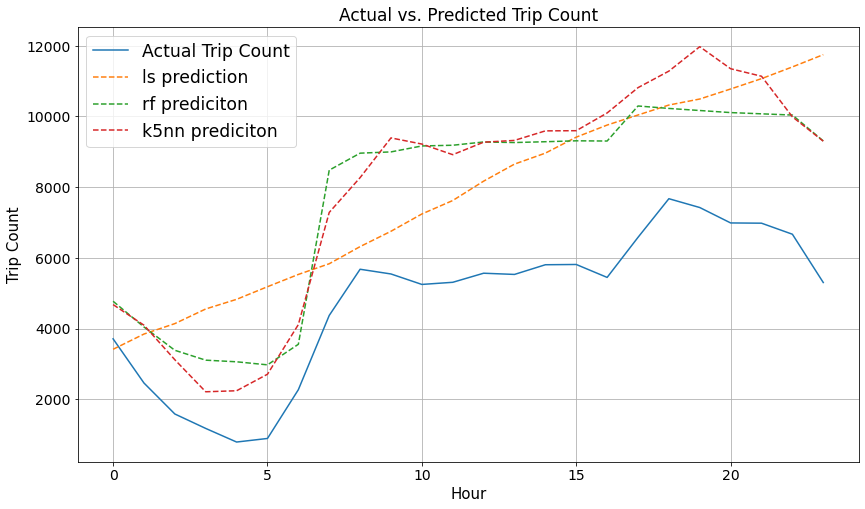

In [24]:
# Plot the actual and predicted trip counts
plt.figure(figsize=(14, 8))
plt.plot(hour_values, actual_average_demand, label="Actual Trip Count")
plt.plot(hour_values, average_ls_pred, label="ls prediction", linestyle="--")
plt.plot(hour_values, average_rf_pred, label="rf prediciton", linestyle="--")
plt.plot(hour_values, average_k5nn_pred, label="k5nn prediciton", linestyle="--")
plt.xlabel("Hour",fontsize=15)
plt.ylabel("Trip Count",fontsize=15)
plt.title("Actual vs. Predicted Trip Count",fontsize=17)
plt.xticks(fontsize=14)  # Adjust fontsize as needed
plt.yticks(fontsize=14)  # Adjust fontsize as needed
plt.legend(fontsize='xx-large')
plt.grid(True)
# Save the plot to an image file
output_image_path = "../plots/predition.png"
plt.savefig(output_image_path)

plt.show()


Notice there is significant data different in number of taxi data per month
Our taining data consist of 35960309 number of trip records, which approximate 5993384 records per month 
where as our test data only contain taxi record in march of 2019 with 3443252 records per month. 

below we will repeat modelling with a sampled training data. 
to do this we will randomly sample two third of data from taxi data as our training data

In [25]:
sampled_taxi = taxi_sdf.sample(fraction=0.66, seed=1)  # Using a seed for reproducibility
sampled_taxi.count()

22033774

In [26]:
# Group by the hour of the day and calculate the average trip duration and tip amount
gb_sampled_taxi = sampled_taxi.groupBy('pickup_day',"hour").agg(
    F.count("*").alias("trip_count"),
)

In [27]:
# Join the taxi and weather data, based on date and hour time 
full_sdf = gb_sampled_taxi.join(weather_sdf, (gb_taxi["pickup_day"] == weather_sdf["date"]) & (gb_taxi["hour"] == weather_sdf["hour_of_the_day"]), "inner")

# transform the windspeed with natural log
full_sdf = full_sdf.withColumn('log(windspeed)', log(full_sdf['windspeed']+1)) # add 1 to aviod zero windspeed

# Drop irrelevant feature to form our traning data 
train = full_sdf.drop("pickup_day", "hour_of_the_day", 'snow', 'feelslike', 'sealevelpressure', 'date' ,'windspeed', 'cloudcover')


We don't have to do extra filtering for test data 

In [28]:
test = spark.read.parquet('../data/curated/test_data/*')

# model with new training data

In [29]:
train_data = train
test_data = test

In [30]:
# categorical data to be index
categorical_features = ["day_of_the_week", "conditions"]

# Apply string indexing to categorical features
indexers = [StringIndexer(inputCol=feature, outputCol=f"{feature}_index") for feature in categorical_features]

train_indexed_data = train_data
test_indexed_data = test_data

for indexer in indexers:
    train_indexed_data = indexer.fit(train_indexed_data).transform(train_indexed_data)
    test_indexed_data = indexer.fit(test_indexed_data).transform(test_indexed_data)


# Assemble features into a vector column
feature_columns = ["day_of_the_week_index", "conditions_index", "hour", "temp", "log(windspeed)", "humidity"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

train_data_with_features = assembler.transform(train_indexed_data)
test_data_with_features = assembler.transform(test_indexed_data)

In [31]:
result = test_data.select("hour", "trip_count").toPandas()

### Linear regression 

In [32]:
# Create a LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="trip_count")

# Fit the model to the training data
lr_model = lr.fit(train_data_with_features)

# Make predictions on the test data 
test_predictions = lr_model.transform(test_data_with_features)

# save the prediction to the result dataframe
result["linear regression prediction"] =test_predictions.select("prediction").toPandas()


23/08/20 19:36:38 WARN Instrumentation: [a28f5ad4] regParam is zero, which might cause numerical instability and overfitting.


### random forest regression 

In [33]:
# Create a RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="trip_count")

# Fit the model to the training data
rf_model = rf.fit(train_data_with_features)

# Make predictions on the test data
test_predictions = rf_model.transform(test_data_with_features)

# save the prediction to the result dataframe
result["rf regression prediction"] =test_predictions.select("prediction").toPandas()


### KNN

In [34]:
# Convert the indexed train and test data to Pandas DataFrames
train_data_pandas = train_indexed_data.toPandas()
test_data_pandas = test_indexed_data.toPandas()

In [35]:
# Prepare the features and target
feature_columns = ["day_of_the_week_index", "conditions_index", "hour", "temp", "log(windspeed)", "humidity"]
X_train = train_data_pandas[feature_columns]
y_train = train_data_pandas["trip_count"]
X_test = test_data_pandas[feature_columns]
y_test = test_data_pandas["trip_count"]


In [36]:
# Create a KNeighborsRegressor model
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
knn_test_predictions = knn.predict(X_test)

# save to result dataframe
result["k(5)nn regression prediction"] =knn_test_predictions


In [37]:
average_result = result.groupby("hour").agg(
    actual_average_taxi_demand=pd.NamedAgg(column="trip_count", aggfunc="mean"),
    average_lr_prediction=pd.NamedAgg(column="linear regression prediction", aggfunc="mean"),
    average_rf_prediciton=pd.NamedAgg(column="rf regression prediction", aggfunc="mean"),
    average_k5nn_prediction=pd.NamedAgg(column="k(5)nn regression prediction", aggfunc = 'mean')
).reset_index()


In [38]:
# Convert Pandas Series to Numpy arrays for indexing
hour_values = average_result["hour"].values
actual_average_demand = average_result["actual_average_taxi_demand"].values
average_ls_pred = average_result["average_lr_prediction"].values
average_rf_pred = average_result["average_rf_prediciton"].values
average_k5nn_pred = average_result["average_k5nn_prediction"].values


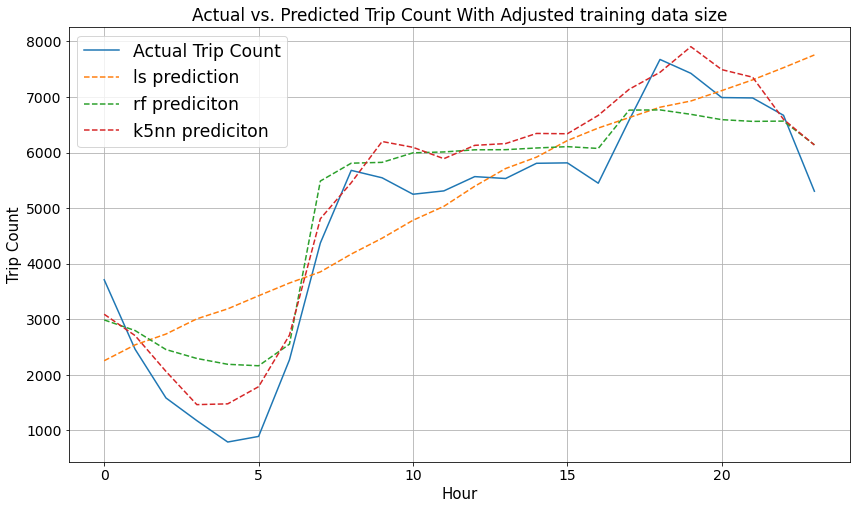

In [39]:
# Plot the actual and predicted trip counts
plt.figure(figsize=(14, 8))
plt.plot(hour_values, actual_average_demand, label="Actual Trip Count")
plt.plot(hour_values, average_ls_pred, label="ls prediction", linestyle="--")
plt.plot(hour_values, average_rf_pred, label="rf prediciton", linestyle="--")
plt.plot(hour_values, average_k5nn_pred, label="k5nn prediciton", linestyle="--")
plt.xlabel("Hour", fontsize=15)
plt.ylabel("Trip Count", fontsize=15)
plt.title("Actual vs. Predicted Trip Count With Adjusted training data size", fontsize=17)
plt.xticks(fontsize=14)  # Adjust fontsize as needed

plt.yticks(fontsize=14)  # Adjust fontsize as needed

plt.legend(fontsize='xx-large')
plt.grid(True)
# Save the plot to an image file
output_image_path = "../plots/predition_with_adjusted_data_size.png"
plt.savefig(output_image_path)
plt.show()


In [40]:
average_result.sort_values(by="average_k5nn_prediction", ascending=False)


,hour,actual_average_taxi_demand,average_lr_prediction,average_rf_prediciton,average_k5nn_prediction
19,19,7424.733333,6926.695393,6687.107780,7904.060000
20,20,6988.666667,7113.860120,6591.113470,7491.340000
18,18,7674.266667,6814.631748,6766.647300,7443.013333
21,21,6981.800000,7307.123946,6560.188558,7355.100000
17,17,6581.066667,6628.278507,6762.992208,7137.306667
16,16,5447.800000,6440.298419,6073.236518,6667.946667
22,22,6669.366667,7526.312525,6565.147461,6596.406667
14,14,5806.100000,5916.392680,6081.379708,6342.973333
15,15,5813.700000,6214.755553,6105.355630,6337.546667
9,9,5545.100000,4458.188284,5822.916749,6198.066667


In [41]:
linear_regression_rmse = mean_squared_error(average_result["actual_average_taxi_demand"], average_result["average_lr_prediction"], squared=False)
random_forest_rmse = mean_squared_error(average_result["actual_average_taxi_demand"], average_result["average_rf_prediciton"], squared=False)
knn_rmse = mean_squared_error(average_result["actual_average_taxi_demand"], average_result["average_k5nn_prediction"], squared=False)


# Create a pandas DataFrame for the RMSE values
rmse_data = {
    "Model": ["Linear Regression", "Random Forest", "KNN"],
    "RMSE": [linear_regression_rmse, random_forest_rmse, knn_rmse]
}
rmse_df = pd.DataFrame(rmse_data)

# Print the DataFrame as a table
display(rmse_df)

,Model,RMSE
0,Linear Regression,1189.412069
1,Random Forest,712.367692
2,KNN,591.096980
